# 11. RNN을 이용한 텍스트 분류

우리가 명심해야할 것은 이정도입니다.

1. 워드 임베딩의 방법
    - 덴스 벡터로 하는 방법이 있다.
    - 빈도순 인덱싱 방법이 있다.(빈도수가 적은 단어를 쳐낼 수 있다.)
    
2. RNN의 개념
    - hidden_size = 출력의 크기(output_dim)
    - timesteps = 시점의 수 = 각 문서에서의 단어 수.
    - input_dim = 입력의 크기 = 각 단어의 벡터 표현의 차원 수

## 11.2. 스팸 메일 분류하기

케글에서 제공하는 데이터를 가지고 바닐라RNN을 이용한 스팸 메일 분류기를 구현해보겠습니다.

다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns

import keras

Using TensorFlow backend.


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### 11.2.1. Data Understanding

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename="spam.csv")
data = pd.read_csv('spam.csv',
                   encoding='latin1')

In [4]:
data.shape

(5572, 5)

In [5]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


첫 번째 칼럼은 레이블입니다. 두 번째 칼럼은 내용이고, 세 번째 부터는 의미가 없습니다. 날려버립니다.

In [6]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

In [9]:
# 레이블 값 인코딩
data['v1'] = data['v1'].replace(['ham', 'spam'],[0, 1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# 결측값 확인
data.isnull().values.any()

False

In [13]:
# 중복값 확인
data['v2'].nunique(), data['v1'].nunique()
#nunique()는 유니크한 값의 개수를 반환한다.
# unique()는 밸류 자체를 반환한다.

(5169, 2)

shape이 5572였는데 유니크값은 5169입니다. 중복 값이 약 400개 존재합니다. 제거해줍니다.

In [14]:
data.drop_duplicates(subset=['v2'], inplace=True)

In [15]:
data.shape

(5169, 2)

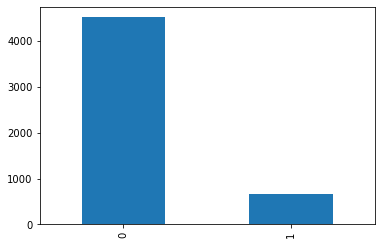

In [18]:
# 레이블 분포 확인
data['v1'].value_counts().plot(kind='bar');

In [19]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [20]:
# feature와 label을 분리해줍니다.

X_data = data['v2']
y_data = data['v1']

### 11.2.2. Preprocessing

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 토큰화를 진행합니다.
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 인덱스로 변환

In [25]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [29]:
# 각 단어에 대한 인덱싱 참고
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'call': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'at': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'when': 46, 'go': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'come': 59, 'am': 60, 'was': 61, 'time': 62, 'its': 63, 'only': 64, 'day': 65, 'want': 66, 'love': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'going': 72, 'one': 73, 'need': 74, 'by': 75, 'lor': 76, 'home': 77, 'as': 78, 'about': 79, 'still': 80, 'see': 81, 'txt': 82, 'back': 83, 'r': 84, 'stop': 85, 'da': 86, 'k': 87, 'today': 88, 'our': 89, "i'll": 90, 'dont': 91, 'reply': 

In [30]:
# 빈도수도 확인할 수 있습니다.
tokenizer.word_counts.items()

odict_items([('go', 271), ('until', 27), ('jurong', 1), ('point', 13), ('crazy', 15), ('available', 16), ('only', 199), ('in', 826), ('bugis', 7), ('n', 131), ('great', 106), ('world', 27), ('la', 7), ('e', 92), ('buffet', 2), ('cine', 7), ('there', 185), ('got', 232), ('amore', 1), ('wat', 95), ('ok', 258), ('lar', 38), ('joking', 6), ('wif', 27), ('u', 1043), ('oni', 4), ('free', 251), ('entry', 21), ('2', 473), ('a', 1293), ('wkly', 9), ('comp', 10), ('to', 2070), ('win', 57), ('fa', 2), ('cup', 6), ('final', 15), ('tkts', 2), ('21st', 2), ('may', 45), ('2005', 2), ('text', 175), ('87121', 2), ('receive', 32), ('question', 18), ('std', 7), ('txt', 148), ('rate', 27), ('t', 65), ("c's", 15), ('apply', 27), ("08452810075over18's", 1), ('dun', 55), ('say', 83), ('so', 439), ('early', 33), ('hor', 2), ('c', 95), ('already', 91), ('then', 233), ('nah', 10), ('i', 2229), ("don't", 129), ('think', 130), ('he', 184), ('goes', 26), ('usf', 11), ('lives', 4), ('around', 61), ('here', 120), ('

빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는지 확인할 수 있습니다.

In [31]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value # 단어 전체 빈도수 총합을 쌓아주고
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt +=1 # 레어 단어 수를 카운트 올리고
        rare_freq += value # 레어 총 빈도 수를 올린다.

In [34]:
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100, 2), " %")
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100, 2), " %")

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02  %
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.08  %


등장 빈도가 1번 이하인 희귀 단어의 수가 매우 많지만 빈도 비율은 6% 밖에 되지 않습니다.

혹시나 등장 빈도가 낮은 단어를 제외하고 싶다면 케라스 토크나이저 선언시 조건을 주면 됩니다.

- tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

이제 단어 집합의 크기를 vocab_size에 저장하겠습니다. 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해주어야 한다는 점입니다.

In [35]:
vocab_size = len(word_to_index) + 1
vocab_size

8921

In [36]:
# 트레인 테스트 데이터 비율 정하기

n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

n_train, n_test

(4135, 1034)

데이터 분포를 확인하고 패딩을 하겠습니다.

In [37]:
X_data = sequences # 토큰화 및 인덱싱 된 피쳐를 때려박아 줍니다.

print("max length : %d" % max(len(l) for l in X_data))
print("avg length : %f" % (sum(map(len, X_data))/len(X_data)))

max length : 189
avg length : 15.610370


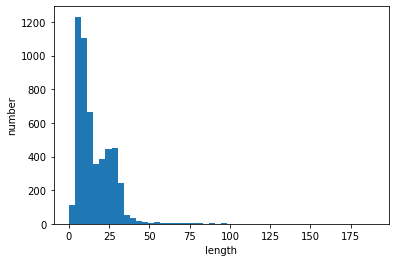

In [38]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel("length")
plt.ylabel('number')
plt.show()

In [39]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.

# 패딩을 해줍니다.
data = pad_sequences(X_data, maxlen=max_len)
data.shape

(5169, 189)

In [43]:
data[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [44]:
# train_test_split

X_test = data[n_train:]
y_test = np.array(y_data[n_train:])
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])

### 11.2.3. Modeling

이제 바닐라RNN을 이용해서 스팸메일 분류기를 만들어보도록 하겠습니다.

In [45]:
from keras.layers import SimpleRNN, Embedding, Dense
from keras.models import Sequential

In [46]:
model = Sequential()

In [47]:
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터는 32차원
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

In [49]:
history = model.fit(X_train,
                    y_train,
                    epochs=4,
                    batch_size=64,
                    validation_split=0.2) # 훈련 데이터의 20%를 검증 데이터로 나눕니다.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3308 samples, validate on 827 samples
Epoch 1/4
3308/3308 [==============================] - 3s 797us/step - loss: 0.5023 - acc: 0.8038 - val_loss: 0.3636 - val_acc: 0.8730
Epoch 2/4
3308/3308 [==============================] - 2s 683us/step - loss: 0.2366 - acc: 0.9181 - val_loss: 0.1032 - val_acc: 0.9734
Epoch 3/4
3308/3308 [==============================] - 2s 671us/step - loss: 0.0658 - acc: 0.9849 - val_loss: 0.0617 - val_acc: 0.9794
Epoch 4/4
3308/3308 [==============================] - 2s 718us/step - loss: 0.0399 - acc: 0.9897 - val_loss: 0.0586 - val_acc: 0.9794


In [50]:
print(model.evaluate(X_test, y_test)[1])

1034/1034 [==============================] - 0s 265us/step
0.9854932427406311


98% 가 나왔습니다.

시각화를 해보겠습니다.

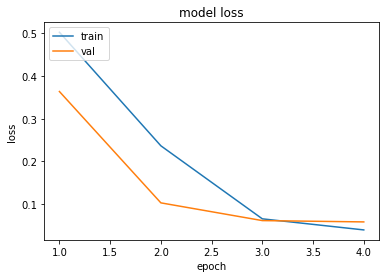

In [51]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

크로스 포인트가 에포크 3 ~ 3.5 사이에서 일어나는 것을 알 수 있습니다. 그 이상은 오버피팅이 됩니다.

## 11.3. 로이터 뉴스 분류하기

이번 챕터에서는 케라스에서 제공하는 로이터 뉴스 데이터를 LSTM을 이용하여 텍스트 분류를 진행해보도록 하겠습니다.

### 11.3.1. 로이터 뉴스 데이터에 대한 이해

In [4]:
from keras.datasets import reuters

Using TensorFlow backend.


In [6]:
(X_train, y_train), (X_test, y_test)=reuters.load_data(num_words=None,
                                                        test_split=0.2)

num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절합니다. 예를 들어 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용하게 됩니다.

In [7]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [8]:
print(X_train[0]) # 첫번째 훈련용 뉴스 기사
print(y_train[0]) # 첫번째 훈련용 뉴스 기사의 레이블

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


토큰화와 정수화가 끝난 상태입니다.

뉴스 기사의 최대 길이: 2376
뉴스 기사의 평균 길이: 145.5398574927633


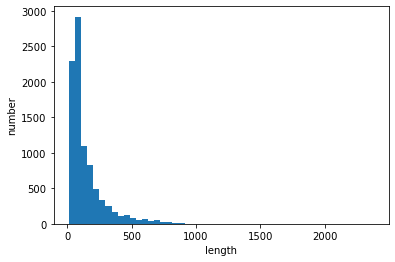

In [9]:
print('뉴스 기사의 최대 길이: {}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이: {}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

대체적으로 대부분의 뉴스는 100~200 사이의 길이를 가지는 것으로 알 수 있습니다.

이제 각 뉴스가 어떤 종류의 뉴스에 속하는지 기재되어있는 레이블 값의 분포를 살펴보겠습니다.

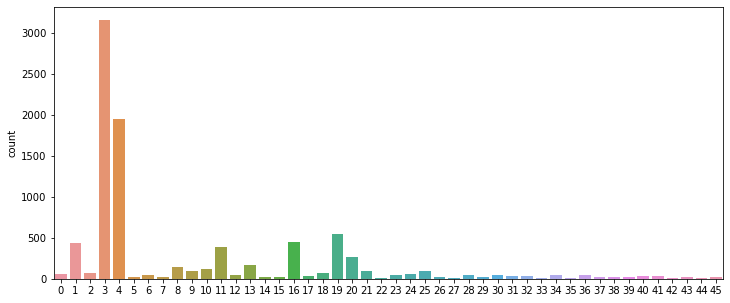

In [13]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)
sns.countplot(y_train)
plt.show()

3번과 4번이 가장 많습니다. 19번과 16번, 1번, 11번도 적당히 있습니다.

In [14]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
# 이렇게 하면 유니크 값과 빈도 수를 받는 구나. 오호 유레카.
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 11.3.2. LSTM으로 로이터 뉴스 분류하기

In [15]:
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

학습에는 등장 빈도 순서가 가장 많은 1 ~ 1,000번째인 단어들만 사용하겠습니다.

In [16]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000,
                                                        test_split=0.2)

In [22]:
# 평균 길이는 145였으나 100으로 패딩을 하겠습니다.

max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [24]:
# 그 다음 레이블 데이터에 원핫인코딩을 해줍니다.
# 원래 레이블은 46개 클래스였습니다.

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

모델링 하겠습니다.

In [26]:
model = Sequential()

In [27]:
# Embedding 레이어의 인자는 vocab_size와 Embedding Dimension 입니다.
# vocab_size는 상위 1,000개만 받아왔으니 당연히 1,000개입니다.
# 임베딩 벡터 차원은 120개로 가겠습니다.

# Dense 레이어는 46개의 클래스를 분류해야 하므로 46의 차원을 인풋합니다.
# 또한 softmax로 다중클래스 분류 확률 분포를 뽑아냅니다.
model.add(Embedding(1000,120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

In [28]:
# val_data의 loss가 증가하면 과적합 징후이므로, 4회 증가할 경우 Early Stopping 시키겠습니다.
# 또한 model checkpoint를 사용하여 val_data의 정확도val_acc가 이전보다 좋아질 경우에만 모델을 저장합니다.

es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=4)

mc = ModelCheckpoint('best_model.h5',
                    monitor='val_acc',
                    mode='max',
                    verbose=1,
                    save_best_only=True)

In [29]:
# compile 하겠습니다.

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5566      
Total params: 241,246
Trainable params: 241,246
Non-trainable params: 0
_________________________________________________________________


In [31]:
# train 합니다. val_data로 X_test, y_test 를 사용합니다.
# val_loss가 증가하는 상황이 오면 overfitting으로 판단하기 위함입니다.

history = model.fit(X_train,
                    y_train,
                    batch_size=128,
                   epochs=30,
                   callbacks=[es, mc],
                   validation_data=(X_test, y_test))

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8982/8982 [==============================] - 34s 4ms/step - loss: 2.6361 - acc: 0.3305 - val_loss: 2.3971 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
Epoch 2/30
8982/8982 [==============================] - 34s 4ms/step - loss: 2.1600 - acc: 0.4216 - val_loss: 1.8912 - val_acc: 0.5116

Epoch 00002: val_acc improved from 0.36198 to 0.51158, saving model to best_model.h5
Epoch 3/30
8982/8982 [==============================] - 33s 4ms/step - loss: 1.8323 - acc: 0.5210 - val_loss: 1.7582 - val_acc: 0.5521

Epoch 00003: val_acc improved from 0.51158 to 0.55209, saving model to best_model.h5
Epoch 4/30
8982/8982 [==============================] - 32s 4ms/step - loss: 1.6878 - acc: 0.5612 - val_loss: 1.7077 - val_acc: 0.5779

Epoch 00004: val_acc improved from 0.55209 to 0.57792, saving model to best_model.h5
Epoch 5/30
8982/8982 [==============================] - 32s 4ms/step - 

훈련이 다 되었다면 베스트 모델을 로드하고 성능을 평가합니다.

In [32]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2246/2246 [==============================] - 3s 1ms/step

 테스트 정확도: 0.7155


model.fit()에서 val_data는 실제 기계가 훈련하지는 않고 정확도와 loss를 판단하기 위한 용도로만 사용합니다. 그래서 model.evaluate()에서 다시 사용해도 문제가 없습니다. 물론 데이터가 많다면 다른 데이터셋으로 하는 게 좋긴 합ㄴ디ㅏ.

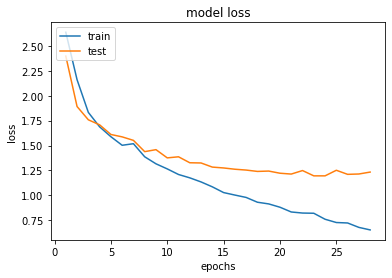

In [33]:
# 에포크마다 변화하는 훈련데이터와 검증데이터의 손실을 시각화해보겠습니다.

epochs = range(1, len(history.history['acc'])+1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

test 데이터가  val_data인데, epochs가 20을 넘어가지 왔다리 갔다리 하죠? overfitting 신호입니다.

## 11.4. IMDB 리뷰 감성 분류하기(IMDB Movie Review Sentiment Analysis)

머신러닝에서 텍스트 분류, 그 중에서도 특히, 감성 분류를 연습하기 위해 자주 사용하는 데이터는 영화 사이트 IMDB의 리뷰 데이터입니다. 해당 리뷰가 긍정일 경우 1, 부정일 경우 0으로 표시한 레이블로 구성된 데이터입니다.

### 11.4.1. Data Understading

In [3]:
from keras.datasets import imdb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# 데이터 로드

(X_train, y_train), (X_test, y_test) = imdb.load_data() # num_words 인자를 넣어주면 해당 빈도 수만큼만

In [5]:
# 데이터 확인

print(len(X_train))
print(len(X_test))
num_classes = max(y_train) +1
print(num_classes)

25000
25000
2


In [6]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


데이터가 토큰화, 정수화가 끝나 있습니다. 레이블은 1과 0으로 되어 있습니다.

참고로 IMDB 데이터는 빈도 순위로 인덱싱을 해주었습니다. 1은 가장 많은 빈도를 가진 단어입니다.

언제나 그렇듯이 리뷰의 길이 분포도를 살펴보겠습니다.

In [7]:
len_result = [len(s) for s in X_train]

print(np.max(len_result))
print(np.mean(len_result))

2494
238.71364


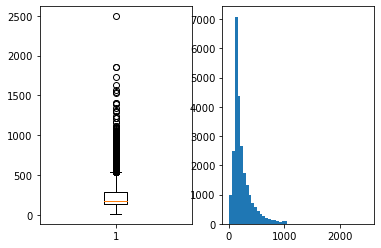

In [9]:
plt.subplot(1, 2, 1)
plt.boxplot(len_result)
plt.subplot(1, 2, 2)
plt.hist(len_result, bins=50)
plt.show()

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [12500 12500]]


In [11]:
# 워드 인덱스 확인

word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [14]:
print('빈도 수 상위 1위 단어: {}'.format(index_to_word[1]))

빈도 수 상위 1위 단어: the


In [15]:
print('빈도 수 상위 357위 단어: {}'.format(index_to_word[357]))

빈도 수 상위 357위 단어: rest


In [17]:
# 디토큰화 확인하기

for index, token in enumerate(("<pad>", "<sos>", "unk")):
    index_to_word[index] = token
    
print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but w

### 11.4.2. LSTM으로 IMDB 리뷰 감성 분류하기

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# 이번에는 작은 단위의 데이터를 가져옵니다.

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

In [20]:
# 패딩

max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [21]:
# 모델 아키텍트

model = Sequential()

In [22]:
model.add(Embedding(5000, 120)) # vocab_size = 5,000 이고 Embedding Dimension은 120차원
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid')) # 1과 0을 분류하기 때문에 sigmoid

In [23]:
es = EarlyStopping(monitor='val_loss', # validate loss로
                  mode = 'min', # 최소기준
                  verbose=1, 
                  patience=3) # 세번 참아라.

mc = ModelCheckpoint('best_model.h5', # 베스트 모델
                    monitor='val_loss', # validate loss로
                    mode='max', # 최대 기준
                    verbose=1, 
                    save_best_only=True) # 베스트 모델만 찾아라.

In [24]:
model.compile(loss='binary_crossentropy', # 이진분류 바이너리, 로스는 크로스엔트로피.
             optimizer='adam',
             metrics=['acc'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         600000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 715,801
Trainable params: 715,801
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,
         y_train,
         validation_data=(X_test, y_test),
         epochs=10,
         batch_size=64,
         callbacks=[es, mc])

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
24960/25000 [============================>.] - ETA: 0s - loss: 0.4366 - acc: 0.7899

KeyboardInterrupt: 

In [ ]:
# 또 오지게 걸리는군요.

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

## 11.5. 나이브 베이즈 분류기(Naive Bayes Classifier)

나이브 베이즈에 대한 정리는 본문을 참고하시기 바랍니다. 조건부 확률 필수!

### 11.5.3. 뉴스그룹 데이터 분류하기

사이킷런에서 제공하는 텍스트 분류의 고전, 뉴스그룹 데이터입니다.

In [2]:
import sklearn

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [27]:
newsdata = fetch_20newsgroups(subset='train')
# subset 인자에 all을 넣으면 전체 데이터 다운로드
# train을 받으면 train만
# test를 받으면 test만
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [6]:
print(len(newsdata.data), len(newsdata.filenames), len(newsdata.target_names), len(newsdata.target))

11314 11314 20 11314


In [7]:
print(newsdata.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [8]:
print(newsdata.target[9])

4


In [9]:
print(newsdata.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







이제 전처리를 진행해보겠습니다. 나이브 베이즈 분류를 위해서는 BoW로 만들어줄 필요가 있습니다.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [28]:
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(newsdata.data)
print(X_train_dtm.shape)

(11314, 130107)


In [29]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
print(tfidfv.shape)

(11314, 130107)


In [30]:
mod = MultinomialNB()
mod.fit(tfidfv, newsdata.target)

MultinomialNB()

In [31]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
X_test_dtm = dtmvector.transform(newsdata_test.data)
tfidfv_test = tfidf_transformer.transform(X_test_dtm)

predicted = mod.predict(tfidfv_test)

In [32]:
print(accuracy_score(newsdata_test.target, predicted))

0.7738980350504514


## 11.6. 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)

이번 챕터에서는 한국어/한글 데이터에 대해서 텍스트 분류를 수행해보겠습니다.

한국어 데이터는 토큰화를 할 때 형태소 분석기를 사용한다는 점이 다릅니다.

### 11.6.1. 전처리

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1d84bd8d7f0>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
print('훈련용 리뷰 개수: ', len(train_data))

훈련용 리뷰 개수:  150000


In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print('테스트용 리뷰 개수: ', len(test_data))

테스트용 리뷰 개수:  50000


In [8]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 11.6.2. 데이터 정제하기

In [9]:
# 중복샘플 확인

train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [10]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
print(len(train_data))

146183


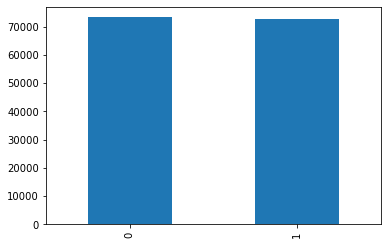

In [12]:
train_data['label'].value_counts().plot(kind='bar')
plt.show()

In [13]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [14]:
print(train_data.isnull().values.any())

True


In [15]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [16]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [17]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


이제 데이터의 전처리를 수행해보겠습니다. 정규표현식을 통해서 특수문자를 제거해보겠습니다.

In [18]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 정규표현식 처리로 인해서 빈 값이 생길 수 있습니다.
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [20]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [21]:
# 테스트 데이터도 동일한 전처리 진행

test_data = test_data.drop_duplicates(subset=['document'])
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].replace('', np.nan)
test_data = test_data.dropna(how = 'any')

print(len(test_data))

48995


### 11.6.3. 토큰화

토큰화를 진행하겠습니다.

기존의 불용어 사전을 사용하지 않고 간단하게 기본적인 것만 쓰겠습니다.

In [22]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

형태소 분석기는 KoNLPy의 Okt를 사용합니다.

In [23]:
# Okt 복습해봅시다.
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',
           stem = True) # stem=True 옵션은 일종의 정규화입니다. '이런'을 '이렇다' 로 바꿔줍니다.

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [24]:
# train_data에 형태소 분석기를 사용해서 토큰화를 하면서 불용어를 제거합니다.
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [25]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [26]:
# test 데이터에도Tokenizer작업

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

### 11.6.4. 정수 인코딩

이제 정수 인코딩을 해보겠습니다.

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 총 합

# 단어 빈도수의 쌍(pair)을 key와 value 로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq += value
    
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if (value < threshold):
        rare_cnt +=1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


희귀 단어 비율이 55% 나 되지만, 등장 빈도 비율은 1.87%이므로 비중이 크지 않다. 전부 삭제

In [30]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print(vocab_size)

19417


In [31]:
# 텍스트 시퀀스를 숫자 시퀀스로 변환합니다.
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [33]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 11.6.5. 빈 샘플 제거

In [34]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [35]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


### 11.6.6. 패딩

72
11.002187371027652


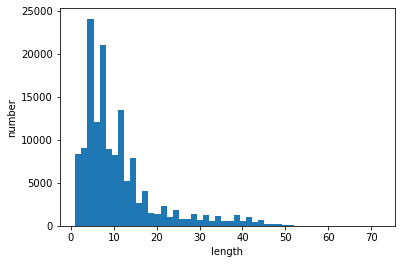

In [36]:
print(max(len(l) for l in X_train))
print(sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

In [37]:
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 11.6.7. 모델링

In [38]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
model = Sequential()

In [40]:
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [41]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=4)

mc = ModelCheckpoint('best_model.h5',
                    monitor='val_acc',
                    mode='max',
                    verbose=1,
                    save_best_only=True)

In [42]:
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['acc'])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1941700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train,
                   epochs=15,
                   callbacks=[es, mc],
                   batch_size=60,
                   validation_split=0.2)

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 116304 samples, validate on 29076 samples
Epoch 1/15
116304/116304 [==============================] - 185s 2ms/step - loss: 0.3899 - acc: 0.8226 - val_loss: 0.3511 - val_acc: 0.8443

Epoch 00001: val_acc improved from -inf to 0.84427, saving model to best_model.h5
Epoch 2/15
116304/116304 [==============================] - 198s 2ms/step - loss: 0.3281 - acc: 0.8561 - val_loss: 0.3358 - val_acc: 0.8556

Epoch 00002: val_acc improved from 0.84427 to 0.85562, saving model to best_model.h5
Epoch 3/15
116304/116304 [==============================] - 178s 2ms/step - loss: 0.3018 - acc: 0.8722 - val_loss: 0.3291 - val_acc: 0.8574 loss: 0.3017 - acc: 0.87

Epoch 00003: val_acc improved from 0.85562 to 0.85737, saving model to best_model.h5
Epoch 4/15
116304/116304 [==============================] - 178s 2ms/step - loss: 0.2829 - acc: 0.8819 - val_loss: 0.3271 - val_acc: 0.8617

Epoch 00004: val_acc improved from 0.85737 to 0.86167, saving model to best_model.h5
Epoch 5/15
116304/11630

In [45]:
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test, y_test)[1])

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


48995/48995 [==============================] - 12s 247us/step
0.8554137945175171


### 11.6.8. Evaluate

이제 직접 작성한 리뷰에 대해서 예측하는 함수를 만들어보겠습니다.

In [51]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen=max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [52]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

92.65% 확률로 긍정 리뷰입니다.



In [53]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

98.96% 확률로 부정 리뷰입니다.



In [54]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

99.86% 확률로 부정 리뷰입니다.



In [55]:
sentiment_predict('감독 뭐하는 놈이냐?')

98.61% 확률로 부정 리뷰입니다.



In [56]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

67.37% 확률로 긍정 리뷰입니다.

